# Решающие деревья

#  I. Немного решающих деревьев
##### Задача 1. Построение "среднего" алгоритма
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [17]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (2 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [18]:
x = np.random.exponential(size=sample_size)
noise = np.random.uniform(low=-1, high=1, size=sample_size)
y = f(x) + noise
regressor = DecisionTreeRegressor()
regressor.fit(x[:, np.newaxis], y)
predictions = regressor.predict(linspace[:, np.newaxis])

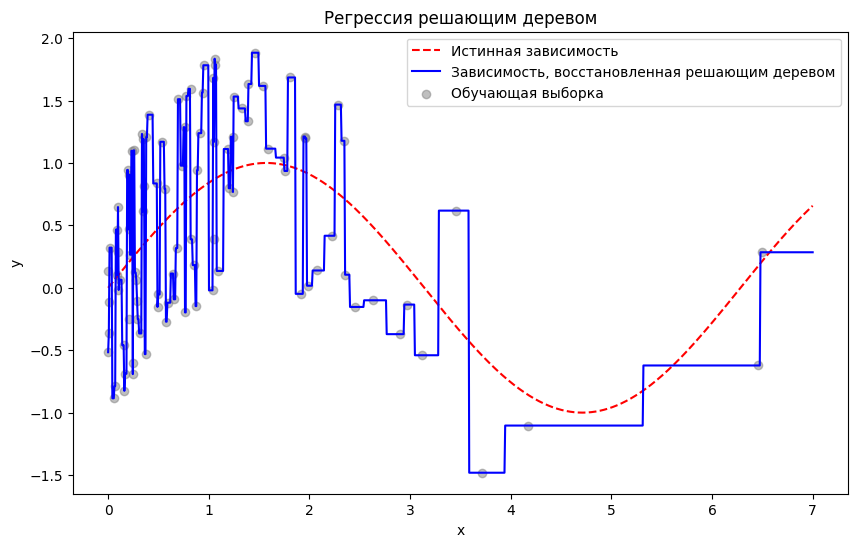

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(linspace, f(linspace), color='red', linestyle='dashed', label='Истинная зависимость')
plt.plot(linspace, predictions, color='blue', label='Зависимость, восстановленная решающим деревом')
plt.scatter(x, y, color='gray', alpha=0.5, label='Обучающая выборка')  
plt.xlabel('x')
plt.ylabel('y')
plt.title('Регрессия решающим деревом')
plt.legend()
plt.show()

__2. (1 балл)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

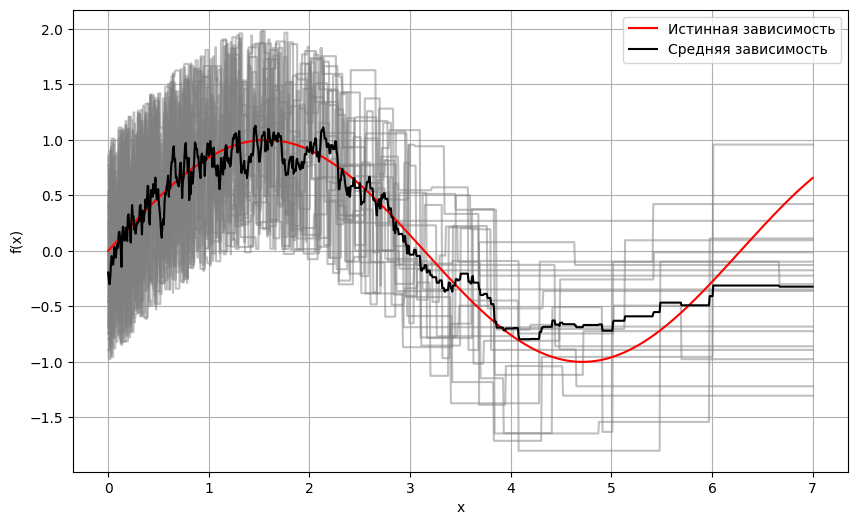

In [20]:
def depth(a):
    predictions = np.zeros((samples_num, len(linspace)))
    plt.figure(figsize=(10, 6))
    for i in range(samples_num):
        x = np.random.exponential(size=sample_size)
        noise = np.random.uniform(low=-1, high=1, size=sample_size)
        y = f(x) + noise
        regressor = DecisionTreeRegressor(max_depth = a)
        regressor.fit(x[:, np.newaxis], y)
        prediction = regressor.predict(linspace[:, np.newaxis])
        predictions[i] = prediction
        plt.plot(linspace, prediction, color='gray', alpha=0.5)
    mean_ = np.mean(predictions, axis=0)
    plt.plot(linspace, f(linspace), color='red', label='Истинная зависимость')
    plt.plot(linspace, mean_, color='black', label='Средняя зависимость')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True)
    plt.show()
depth(None)

__3.(0.5 балл):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

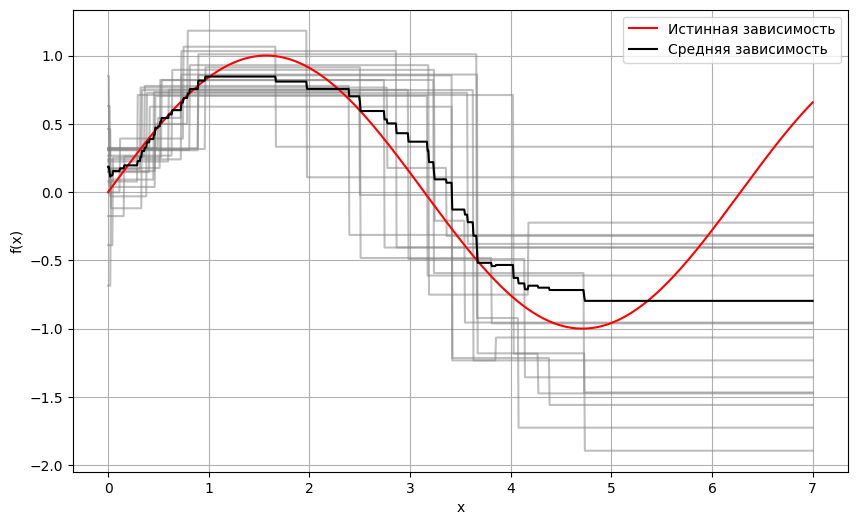

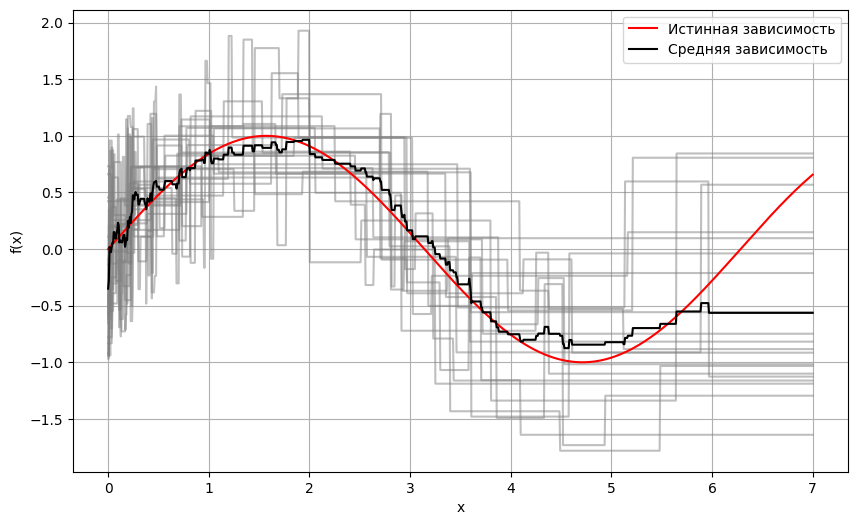

In [21]:
depth(2)
depth(4)

__4. (0.5 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:**

В случае , когда ограничение 4 , потому что переобучения еще не произошло , а обучение уже произошло

### II. Решающие деревья чужими руками

#### Задача 3.
В этой части вам нужно посмотреть на класс написанный за вас для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__8. (1 балл)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [27]:
import pandas as pd
data = pd.read_csv('students.csv')
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [12]:
import numpy as np
from collections import Counter
import sklearn


def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, noise_generator=np.random.uniform,
                          sample_size=300, samples_num=300, objects_num=200, seed=1234):
    np.random.seed(seed)
    x = x_generator(size=sample_size)
    noise = noise_generator(size=sample_size)
    samples = []
    noise_s = []
    for i in range(samples_num):
        xt = x_generator(size=sample_size)
        noise_st = noise_generator(size=sample_size)
        samples.append(xt)
        noise_s.append(noise_st)
    return compute_bias_variance_fixed_samples(regressor, dependence_fun, samples, x, noise_s, noise.mean())


def compute_bias_variance_fixed_samples(regressor, dependence_fun, samples, objects, noise, mean_noise):
    res = []
    for i in range(len(samples)):
        yt = dependence_fun(samples[i]) + noise[i]
        regressor.fit(samples[i][:, np.newaxis], yt)
        res.append(regressor.predict(objects[:, np.newaxis]))
    res = np.array(res)
    E = sum(res) / len(samples)
    bias = np.mean((E - (dependence_fun(objects) + mean_noise)) ** 2, axis=0)
    variance = np.mean(np.mean((res - E) ** 2, axis=0), axis=0)
    return bias, variance


def H(div):
    z = np.count_nonzero(div)
    nz = div.shape[0] - z
    z /= div.shape[0]
    nz /= div.shape[0]
    return 1 - z**2 - nz**2


def find_best_split(feature_vector, target_vector):
    m = np.array([feature_vector, target_vector])
    m = m.T
    m = m[m[:, 0].argsort()]
    m = m.T
    sort = m
    if (sort[0][0] == sort[0][-1]):
        return None
    sort2 = np.copy(sort)
    sort3 = np.copy(sort)
    sort3 = np.delete(sort3, 0, axis=1)
    sort2 = np.delete(sort2, -1, axis=1)
    thresholds = (sort3[0] + sort2[0]) / 2
    l = len(thresholds)
    ginis = np.zeros(l)
    for i in range(0, len(thresholds)):
        fg = i + 1
        l = sort[0].shape[0]
        left = -fg / l
        right = -(l - fg) / l
        ginis[i] = left * H(sort[1][:fg]) + right * H(sort[1][fg:])
    mi = np.argmax(ginis)
    return thresholds, ginis, thresholds[mi], ginis[mi]


class DecisionTree():
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self._depth = None

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if np.all(feature_vector[0] == feature_vector):
                continue

            best_split_found = find_best_split(feature_vector, sub_y)
            if best_split_found is None:
                continue

            _, _, threshold, gini = best_split_found
            if gini_best is None or gini > gini_best:
                a = feature_vector <= threshold
                if not ((len(sub_y[a]) == 0) or (len(sub_y[a]) == len(sub_y))):
                    feature_best = feature
                    gini_best = gini
                    split = feature_vector <= threshold
                    if feature_type == "real":
                        threshold_best = threshold
                    elif feature_type == "categorical":
                        threshold_best = list(map(lambda x: x[0],
                                                  filter(lambda x: x[1] <= threshold, categories_map.items())))
                    else:
                        raise ValueError
        if(len(sub_y[split]) == len(sub_y)):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]

        feature_split = node["feature_split"]
        if (self._feature_types[feature_split] == "real" and x[feature_split] <= node["threshold"]) or \
                (self._feature_types[feature_split] == "categorical" and x[feature_split] in node["categories_split"]):
            return self._predict_node(x, node["left_child"])
        else:
            return self._predict_node(x, node["right_child"])

    def fit(self, X, y):
        X = X.astype(np.float64)
        y = y.astype(np.float64)
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


In [13]:
from importlib import reload
from matplotlib import pyplot as plt

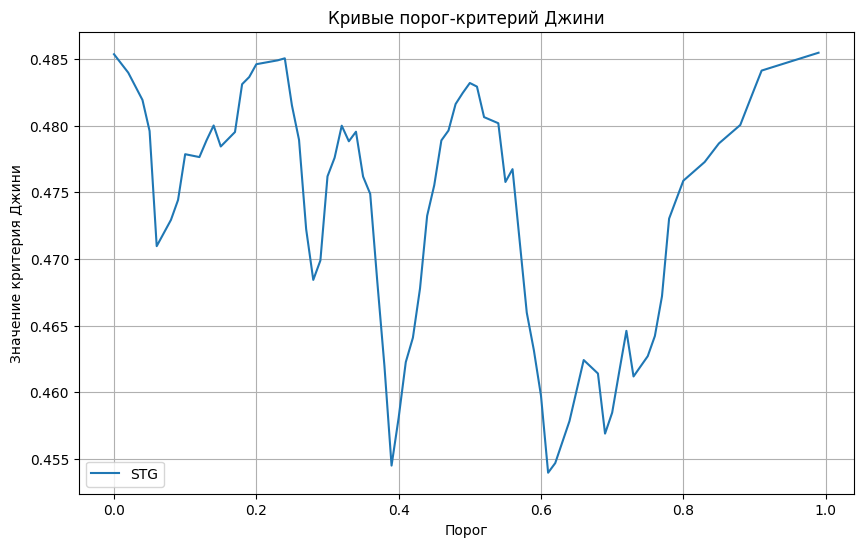

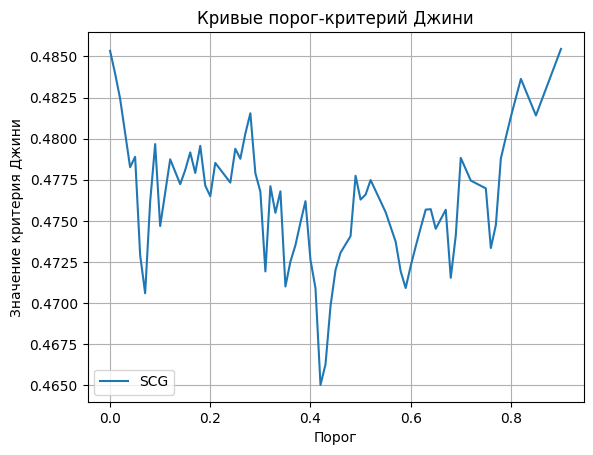

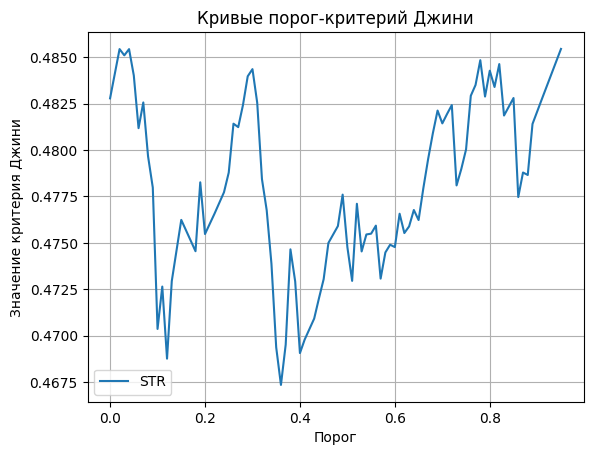

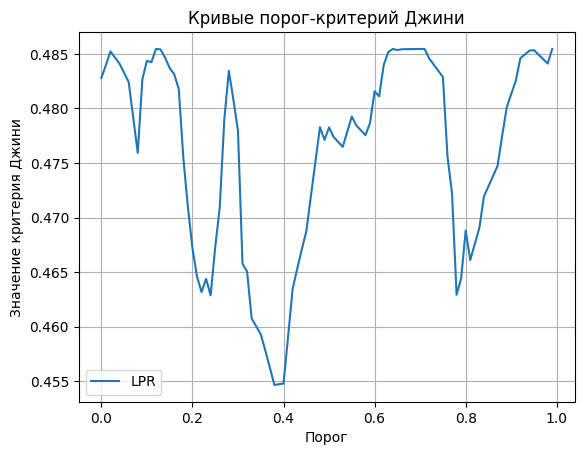

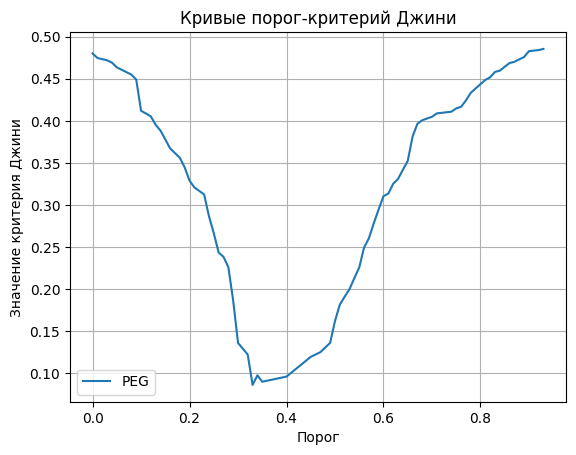

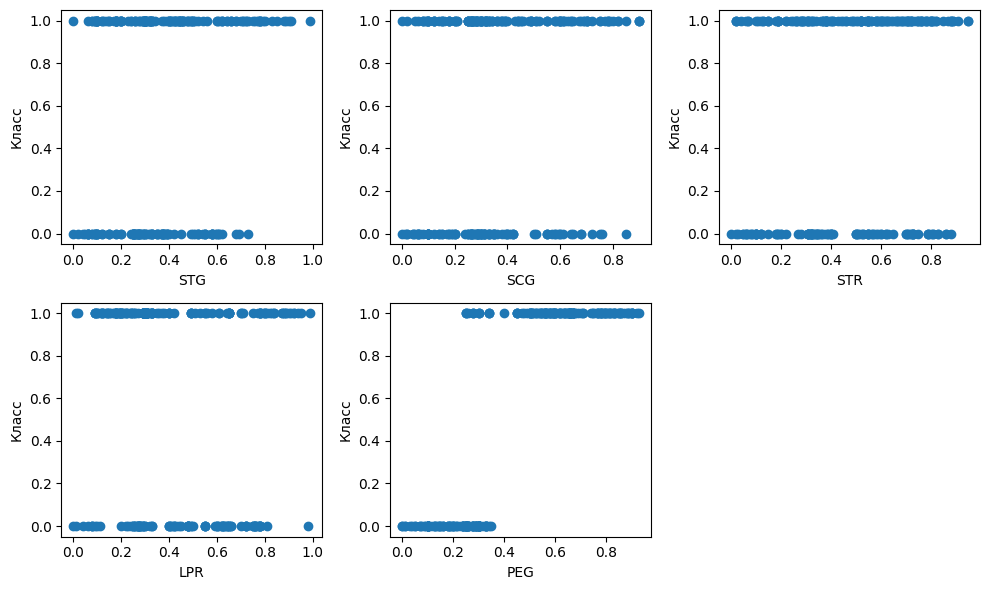

In [28]:
data = pd.read_csv('students.csv')
data2 = data.iloc[:, :5]
target = data.iloc[:, -1]

def gini_index(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    gini = 1 - np.sum(probabilities ** 2)
    return gini


plt.figure(figsize=(10, 6))

for feature in data2.columns:
    values = data2[feature]
    unique_ = np.sort(np.unique(values))
    ginis = []
    for i in unique_:
        lft = values <= i
        rgt = values > i
        left_gini = gini_index(target[lft])
        right_gini = gini_index(target[rgt])
        gini = (sum(lft) / len(target)) * left_gini + (sum(rgt)) / len(target) * right_gini
        ginis.append(gini)
    plt.plot(unique_, ginis, label=feature)
    plt.xlabel('Порог')
    plt.ylabel('Значение критерия Джини')
    plt.title('Кривые порог-критерий Джини')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
for i, j in enumerate(data2.columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(data2[j], target)
    plt.xlabel(j)
    plt.ylabel('Класс')
    plt.tight_layout()
plt.show()

__9. (1 балл)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Для PEG наиболее подходящими являются кривые, которые сначала убывают, а затем возрастают. График рассеяния для PEG также показывает, что существует точка x, в которой наблюдается резкое изменение: до этой точки очень мало объектов с классом 1, а после неё их количество резко увеличивается. Это указывает на минимальное количество объектов, которые не соответствуют ограничению: либо объекты с классом 0 и значением PEG меньше x, либо объекты с классом 1 и значением PEG больше или равно x. Противоположное утверждение будет выглядеть так: либо объекты с классом 1 и значением PEG меньше x, либо объекты с классом 0 и значением PEG больше или равно x.

__10. (1 балл)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [35]:
#NOT FOUND - при переходе по ссылке